In [1]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import multiprocessing as mp
import pandas as pd
import seaborn as sns
import numpyro as npr
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO, TraceMeanField_ELBO, autoguide
from numpyro.optim import Adam
from numpyro.infer.reparam import TransformReparam
from numpyro.distributions import constraints
from jax import random
import jax.numpy as jnp
import jax.scipy.special as jss
import scipy

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set()
npr.set_host_device_count(mp.cpu_count())

# From the doc

In [2]:
def model(data):
    # define the hyperparameters that control the beta prior
    alpha0 = 10.0
    beta0 = 10.0
    # sample f from the beta prior
    f = npr.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # loop over the observed data
    with npr.plate("observations", len(data)):
        # observe datapoint i using the bernoulli
        # likelihood Bernoulli(f)
        npr.sample("obs", dist.Bernoulli(f), obs=data)

In [3]:
def guide(data):
    # register the two variational parameters with Pyro.
    alpha_q = npr.param("alpha_q", 10.0,
                        constraint=constraints.positive)
    beta_q = npr.param("beta_q", 10.0,
                       constraint=constraints.positive)
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    npr.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

In [4]:
# create some data with 6 observed heads and 4 observed tails
data = jnp.concatenate([jnp.ones(6), jnp.zeros(4)])

In [5]:
# set up the optimizer
optimizer = Adam(step_size=0.0005)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

svi_result = svi.run(random.PRNGKey(0), 5000, data)

100%|██████████| 5000/5000 [00:04<00:00, 1105.56it/s, init loss: 6.8098, avg. loss [4751-5000]: 7.1197]


In [6]:
params = svi_result.params
params

{'alpha_q': DeviceArray(11.536084, dtype=float32),
 'beta_q': DeviceArray(10.208612, dtype=float32)}

In [7]:
params["alpha_q"] / (params["alpha_q"] + params["beta_q"])

DeviceArray(0.530524, dtype=float32)

# Other example from the doc

In [8]:
def model(W, L):
    p = npr.sample("p", dist.Uniform(0, 1))  # uniform prior
    npr.sample("W", dist.Binomial(W + L, p), obs=W)  # binomial likelihood


guide = autoguide.AutoLaplaceApproximation(model)
svi = SVI(model, guide, Adam(1), Trace_ELBO(), W=6, L=3)
params, losses = svi.run(random.PRNGKey(0), 1000)

# display summary of quadratic approximation
samples = guide.sample_posterior(random.PRNGKey(1), params, (1000,))
npr.diagnostics.print_summary(samples, prob=0.89, group_by_chain=False)

100%|██████████| 1000/1000 [00:00<00:00, 1336.71it/s, init loss: 2.9278, avg. loss [951-1000]: 2.7795]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         p      0.62      0.14      0.63      0.41      0.84    845.27      1.00



In [9]:
print(params)

{'auto_loc': DeviceArray([0.5596159], dtype=float32)}


# Simple model

In [10]:
np.random.seed(123)

# Parameters to be inferred
alpha = 4.0
beta = 0.5
sigma = 1.0

# Generate and plot data
x = 10 * np.random.rand(1000)
y = alpha + beta * x
y = np.random.normal(y, scale=sigma)

# Put our data in a dictionary
data = {'N': len(x), 'x': x, 'y': y}

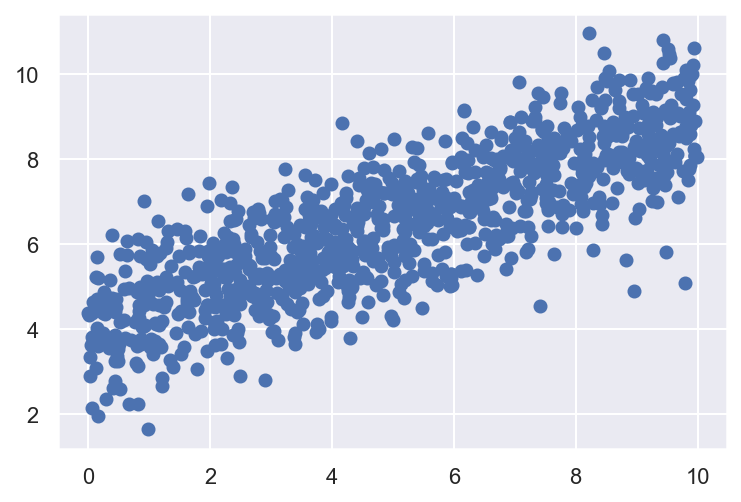

In [11]:
plt.scatter(x, y)

In [12]:
def model():

    alpha = npr.sample("alpha", dist.Normal(0, 10))
    beta = npr.sample("beta",  dist.Normal(0, 10))
    sigma = npr.sample("sigma", dist.LogNormal(0, 10))
    mu = alpha + beta * x
    with npr.plate("data", len(y)):
        npr.sample("obs", dist.Normal(mu, sigma), obs=y)

In [13]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000, num_chains=1)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key)

sample: 100%|██████████| 2000/2000 [00:04<00:00, 436.43it/s, 7 steps of size 4.21e-01. acc. prob=0.89] 


In [14]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      4.03      0.06      4.03      3.93      4.12    329.61      1.00
      beta      0.49      0.01      0.49      0.47      0.51    318.77      1.00
     sigma      0.96      0.02      0.96      0.93      1.00    626.35      1.01

Number of divergences: 0


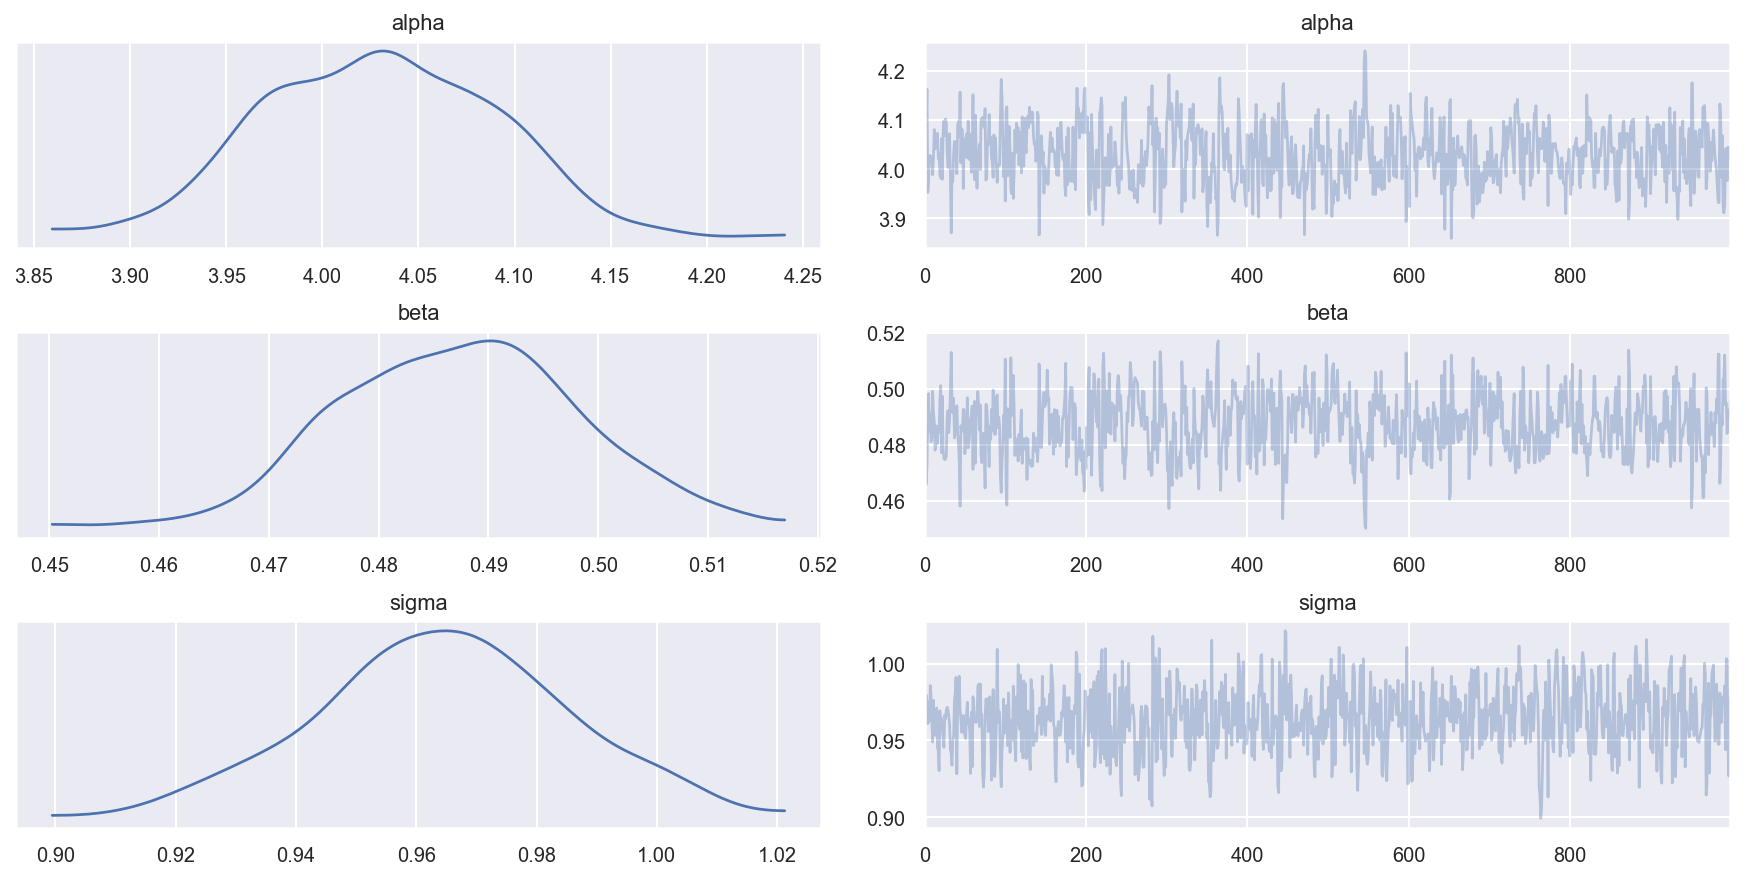

In [15]:
trace = az.from_numpyro(mcmc)
az.plot_trace(trace);

In [16]:
def guide():
    
    alpha_mu = npr.param("alpha_mu", 0.0)
    alpha_sg = npr.param("alpha_sg", 1.0, constraint=constraints.positive)
    alpha = npr.sample("alpha", dist.Normal(alpha_mu, 
                                            alpha_sg))
    
    beta_mu = npr.param("beta_mu", 0.0)
    beta_sg = npr.param("beta_sg", 1.0, constraint=constraints.positive)
    
    beta = npr.sample("beta", dist.Normal(beta_mu, 
                                          beta_sg))
    sigma_a = npr.param("sigma_a", 0.0) # constraint=constraints.positive)
    sigma_b = npr.param("sigma_b", 1.0, constraint=constraints.positive)
    sigma = npr.sample("sigma", dist.LogNormal(sigma_a, sigma_b))

In [17]:
# set up the optimizer
optimizer = Adam(step_size=0.0005)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

svi_result = svi.run(random.PRNGKey(0), 50000)

100%|██████████| 50000/50000 [00:44<00:00, 1132.49it/s, init loss: 364161.4062, avg. loss [47501-50000]: 1399.6750]


In [18]:
params = svi_result.params
params

{'alpha_mu': DeviceArray(4.0257907, dtype=float32),
 'alpha_sg': DeviceArray(0.02965543, dtype=float32),
 'beta_mu': DeviceArray(0.4884876, dtype=float32),
 'beta_sg': DeviceArray(0.00530161, dtype=float32),
 'sigma_a': DeviceArray(-0.03718072, dtype=float32),
 'sigma_b': DeviceArray(0.02266532, dtype=float32)}

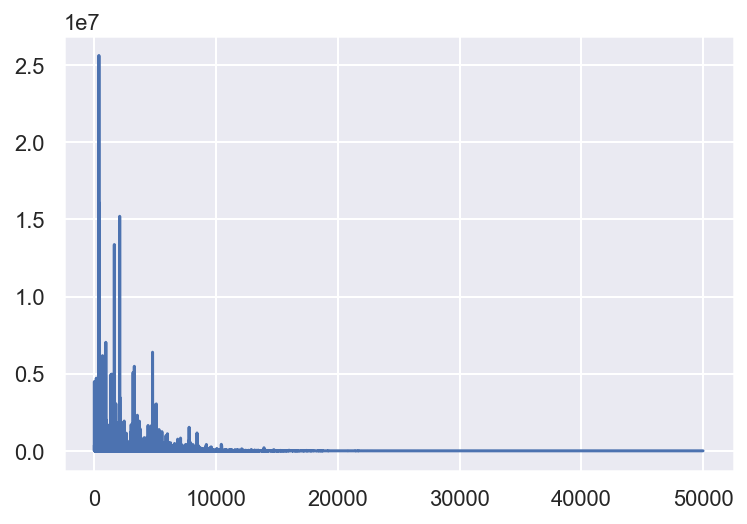

In [19]:
loss = svi_result.losses
plt.plot(loss)

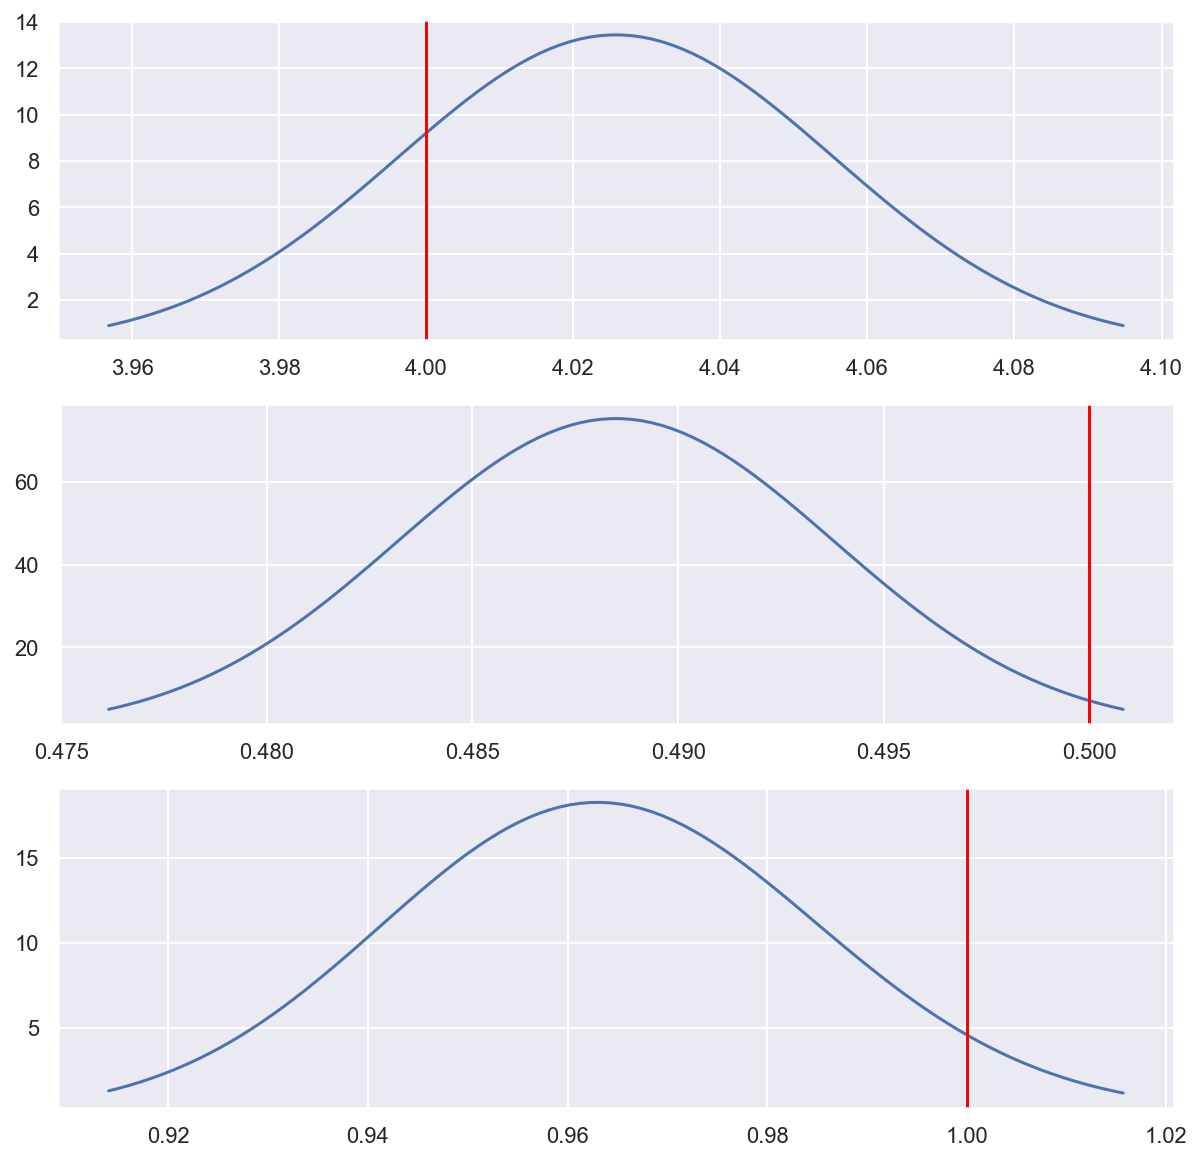

In [20]:
fig, axes = plt.subplots(nrows=3, figsize=(10, 10))

rv = scipy.stats.norm(params['alpha_mu'].item(), params['alpha_sg'].item())
x = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
y = rv.pdf(x)
axes[0].plot(x, y)
axes[0].axvline(alpha, color='red')

rv = scipy.stats.norm(params['beta_mu'].item(), params['beta_sg'].item())
x = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
y = rv.pdf(x)
axes[1].plot(x, y)
axes[1].axvline(beta, color='red')

rv = scipy.stats.lognorm(s=params['sigma_b'].item(), scale=np.exp(params['sigma_a'].item()))
x = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
y = rv.pdf(x)
axes[2].plot(x, y)
axes[2].axvline(sigma, color='red')

# Model

## Data

In [25]:
# Seed
np.random.seed(123)

# Parameterization
mu = 6
sg_theta = 0.5
sg_u = 3
sg_w = 5

n_u = 20   # Number of users
n_w = 20   # Number of words
n_o = 100  # Number of obs per user per word

U = np.random.normal(0, sg_u, size=n_u)   # User ability
W = np.random.normal(0, sg_w, size=n_w)   # Item difficulty

n_obs = n_w*n_u*n_o
u = np.zeros(n_obs, dtype=int)
w = np.zeros(n_obs, dtype=int)
idx = 0
for i_w in range(n_w):
    for i_u in range(n_u):
        u[idx:idx+n_o] = i_u
        w[idx:idx+n_o] = i_w
        idx += n_o

theta = np.random.normal(mu + U[u] + W[w], sg_theta)

In [26]:
np.mean(theta)

4.9412931828600914

## Define the model

In [42]:
def model():
    with npr.handlers.reparam(config={'sg_w': TransformReparam(), 'sg_u': TransformReparam(), 
                                      'sg_theta': TransformReparam()}):
        sg_w = npr.sample("sg_w", 
                          dist.TransformedDistribution(
                              dist.Normal(0., 1.), 
                              dist.transforms.SoftplusTransform()))
        sg_u = npr.sample("sg_u", 
                          dist.TransformedDistribution(
                              dist.Normal(0., 1.),
                              dist.transforms.SoftplusTransform()))
        sg_theta = npr.sample("sg_theta", 
                              dist.TransformedDistribution(
                                  dist.Normal(0., 1.),
                                  dist.transforms.SoftplusTransform()))           
    
    mu = npr.sample("mu", dist.Normal(0., 10.))
    
    mu_u = npr.deterministic("mu_u", 0.)
    with npr.plate("user", n_u):
        U = npr.sample("U", dist.Normal(mu_u, sg_u))
    
    mu_w = npr.deterministic("mu_w", 0.)
    with npr.plate("word", n_w):
        W = npr.sample("W", dist.Normal(mu_w, sg_w))
    
    mu_theta = mu + U[u] + W[w]
    npr.sample("theta", dist.Normal(mu_theta, sg_theta), obs=theta)
    

# Run the model

## MCMC

In [43]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000, num_chains=1)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key)

sample: 100%|██████████| 2000/2000 [07:11<00:00,  4.63it/s, 1023 steps of size 2.66e-03. acc. prob=0.94]


In [44]:
mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
           U[0]     -3.40      0.63     -3.35     -4.44     -2.35      8.60      1.14
           U[1]      2.82      0.63      2.87      1.79      3.87      8.63      1.14
           U[2]      0.68      0.63      0.73     -0.34      1.76      8.63      1.14
           U[3]     -4.69      0.63     -4.65     -5.74     -3.66      8.61      1.14
           U[4]     -1.89      0.63     -1.85     -2.94     -0.85      8.64      1.14
           U[5]      4.77      0.63      4.81      3.72      5.81      8.60      1.14
           U[6]     -7.45      0.63     -7.40     -8.46     -6.37      8.60      1.14
           U[7]     -1.44      0.63     -1.40     -2.49     -0.41      8.62      1.14
           U[8]      3.64      0.63      3.69      2.59      4.67      8.61      1.14
           U[9]     -2.76      0.63     -2.71     -3.81     -1.73      8.63      1.14
          U[10]     -2.22      0.63     -2.17     -3.

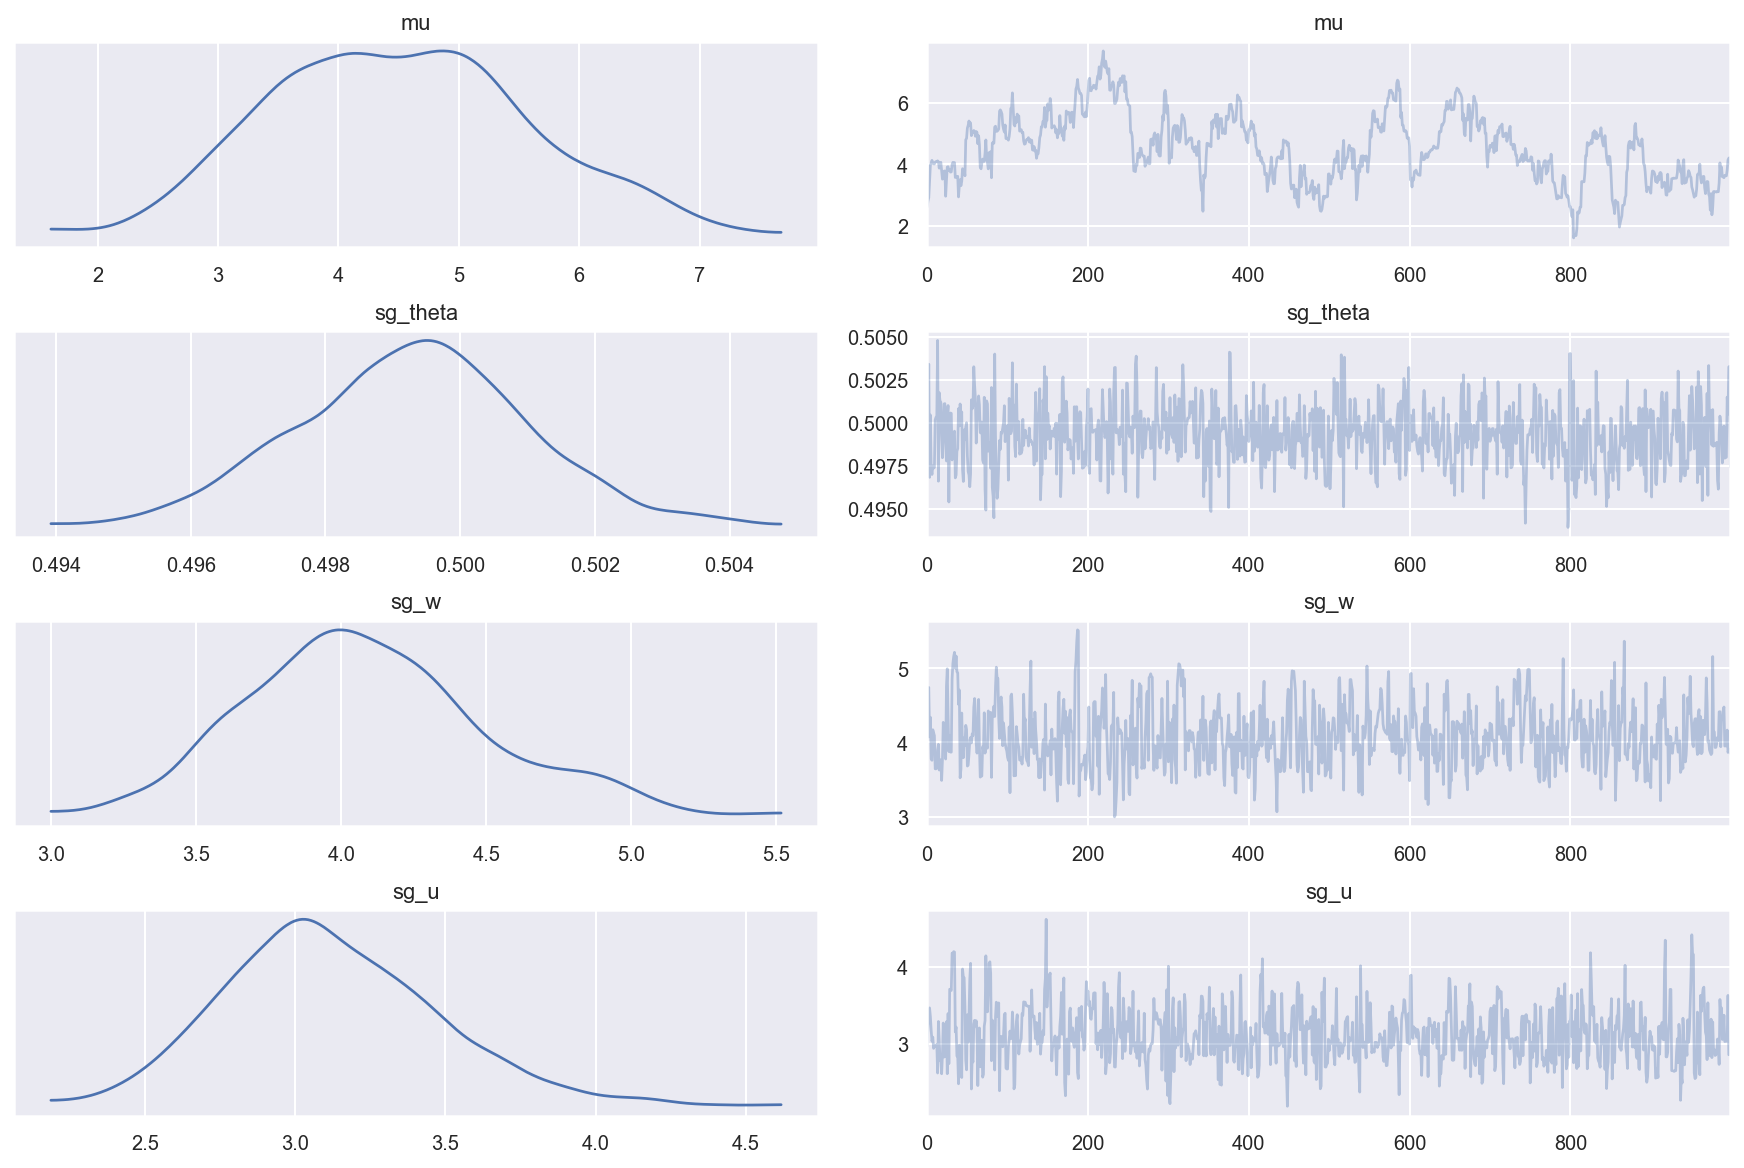

In [45]:
trace = az.from_numpyro(mcmc)
az.plot_trace(trace, var_names=['mu', 'sg_theta', 'sg_w', 'sg_u']);

## VI

In [80]:
def guide():
    
    sg_w_a = npr.param("sg_w_a", 0.0) # constraint=constraints.positive)
    sg_w_b = npr.param("sg_w_b", 1.0, constraint=constraints.positive)
    
    sg_u_a = npr.param("sg_u_a", 0.0)  #, constraint=constraints.positive)
    sg_u_b = npr.param("sg_u_b", 1.0, constraint=constraints.positive)
    
    sg_theta_a = npr.param("sg_theta_a", 0.0) #, constraint=constraints.positive)
    sg_theta_b = npr.param("sg_theta_b", 1.0, constraint=constraints.positive)
    
    with npr.handlers.reparam(config={"sg_w": TransformReparam(),
                                      "sg_u": TransformReparam(),
                                      "sg_theta": TransformReparam()}):
    
        npr.sample("sg_w", dist.TransformedDistribution(
                                dist.Normal(sg_w_a, sg_w_b),
                                dist.transforms.SoftplusTransform()))
        npr.sample("sg_u", dist.TransformedDistribution(
                                dist.Normal(sg_u_a, sg_u_b),
                                dist.transforms.SoftplusTransform()))
        npr.sample("sg_theta", dist.TransformedDistribution(
                                dist.Normal(sg_theta_a, sg_theta_b),
                                dist.transforms.SoftplusTransform()))
    
    mu_a = npr.param("mu_a", 0.0)
    mu_b = npr.param("mu_b", 10.0, constraint=constraints.positive)
    npr.sample("mu", dist.Normal(mu_a, mu_b))

In [82]:
# set up the optimizer
optimizer = Adam(step_size=0.0005)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

svi_result = svi.run(random.PRNGKey(0), 100000)

100%|██████████| 100000/100000 [01:35<00:00, 1051.92it/s, init loss: 11524068.0000, avg. loss [95001-100000]: 131341.9844]


In [83]:
params = svi_result.params
params

{'mu_a': DeviceArray(4.942412, dtype=float32),
 'mu_b': DeviceArray(0.03240008, dtype=float32),
 'sg_theta_a': DeviceArray(6.495561, dtype=float32),
 'sg_theta_b': DeviceArray(0.02258164, dtype=float32),
 'sg_u_a': DeviceArray(-19.989128, dtype=float32),
 'sg_u_b': DeviceArray(1.0099543, dtype=float32),
 'sg_w_a': DeviceArray(-20.001661, dtype=float32),
 'sg_w_b': DeviceArray(0.9968134, dtype=float32)}

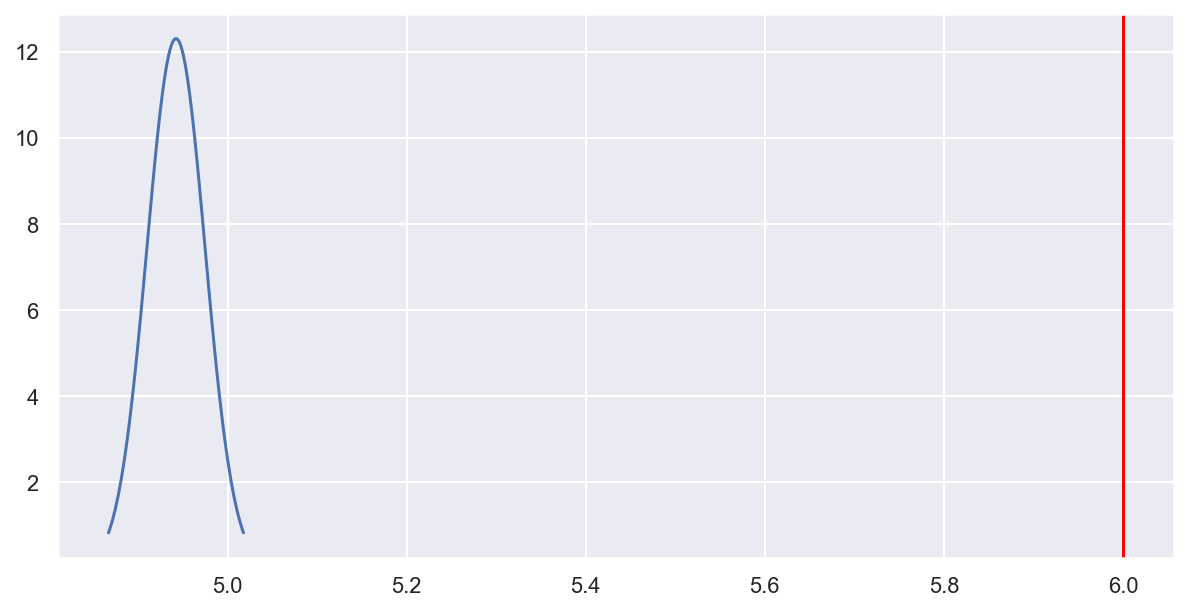

In [84]:
fig, ax = plt.subplots(nrows=1, figsize=(10, 5))

rv = scipy.stats.norm(params['mu_a'].item(), params['mu_b'].item())
x = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
y = rv.pdf(x)
ax.plot(x, y)
ax.axvline(mu, color='red')

# rv = scipy.stats.norm(scale=params['sg_u_a'].item()), s=params['sg_u_b'].item())
# x = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
# y = rv.pdf(x)
# axes[1].plot(x, y)
# axes[1].axvline(sg_u, color='red')

# rv = scipy.stats.lognorm(scale=np.exp(params['sg_w_a'].item()), s=params['sg_w_b'].item())
# x = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
# y = rv.pdf(x)
# axes[2].plot(x, y)
# axes[2].axvline(sg_w, color='red')

# rv = scipy.stats.lognorm(scale=np.exp(params['sg_theta_a'].item()), s=params['sg_theta_b'].item())
# x = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
# y = rv.pdf(x)
# axes[3].plot(x, y)
# axes[3].axvline(sg_theta, color='red')

In [85]:
def softplus(x):
    return np.log(1+np.exp(x))

''

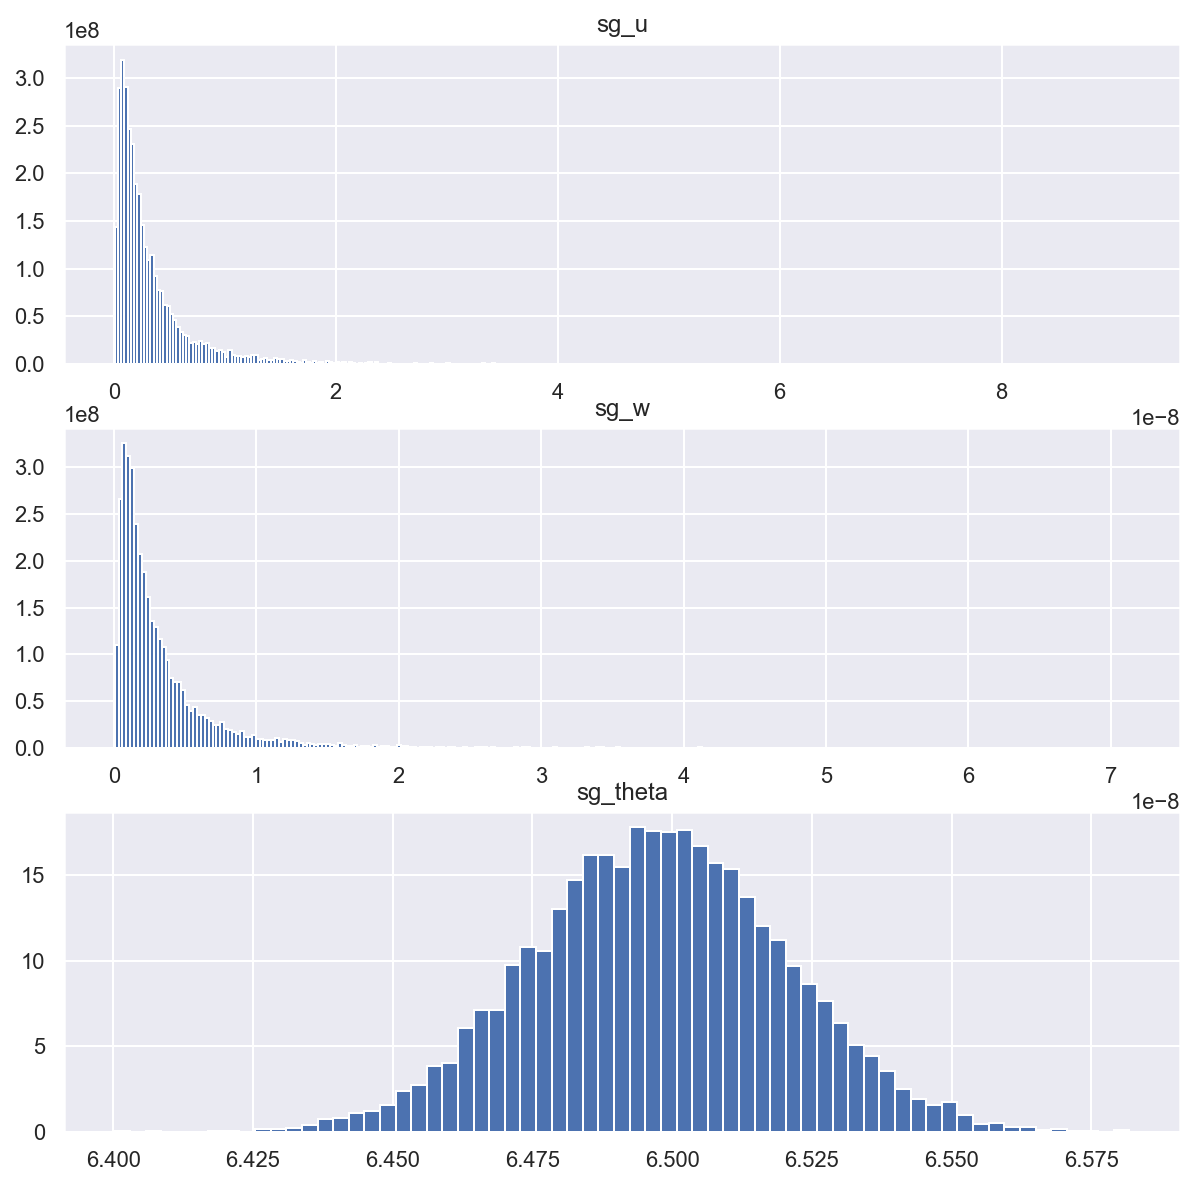

In [86]:
fig, axes = plt.subplots(nrows=3, figsize=(10, 10))
for i, (truth, loc, scale) in enumerate((
        (sg_u, 'sg_u_a', 'sg_u_b'), 
        (sg_w, 'sg_w_a', 'sg_w_b'), 
        (sg_theta, 'sg_theta_a', 'sg_theta_b'))):
    x = softplus(np.random.normal(loc=params[loc].item(), scale=params[scale].item(), size=10000))
    ax = axes[i]
    ax.hist(x, bins='auto', density=True)
    ax.set_title(scale[:-2])
    # ax.axvline(truth, color='red')
;